## 1. Dependencies and Core Libraries

### 1.1 Import Essential Vector-HaSH Components

Import all necessary libraries and modules for comprehensive Vector-HaSH testing:

#### Core Numerical Libraries
- **sys**: System-specific parameters and functions
- **numpy**: Fundamental array operations and mathematical computations
- **matplotlib**: Visualization for capacity curves and performance analysis

#### Vector-HaSH Core Modules
- **assoc_utils_np**: Core associative memory functions (`train_gcpc`, `nonlin`, etc.)
- **sensory_utils**: Sensory processing utilities (`pseudotrain_Wsp`, `pseudotrain_Wps`)
- **data_utils**: Data loading, saving, and preprocessing functions
- **senstranspose_utils**: Transposed sensory mapping utilities
- **theory_utils**: Theoretical analysis and capacity computation functions
- **assoc_utils_np_2D**: 2D grid cell operations (`gen_gbook_2d`, `gridCAN_2d`)

#### Optional Specialized Modules (Commented)
- **sens_pcrec_utils**: Principal component reconstruction utilities
- **sensgrid_utils**: Sensory-grid integration functions
- **sens_sparseproj_utils**: Sparse projection methods for sensory processing

This comprehensive import setup provides all tools needed for full-scale Vector-HaSH capacity analysis, baseline comparisons, and performance evaluation across multiple experimental paradigms.

In [1]:
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from src.assoc_utils_np import *
from src.sensory_utils import *
from src.data_utils import *
from src.senstranspose_utils import *
from src.theory_utils import *
from src.assoc_utils_np_2D import gen_gbook_2d
# from src.sens_pcrec_utils import *
#from src.sensgrid_utils import *
#from src.sens_sparseproj_utils import *

$\textcolor{red}{Ji \ Lab \ newly \ added}$:

If you are using a Windows system and encounter the following warning：

`findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica`

please run the next cell regarding font configuration.

In [2]:
plt.style.use('./src/presentation.mplstyle')
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False 

# Full Model Testing and Capacity Analysis (Figure 3)

## Experiment Overview

This notebook conducts comprehensive testing of the complete Vector-HaSH model to evaluate its memory capacity and performance compared to classical baseline methods. The experiments analyze how Vector-HaSH scales with increasing pattern loads and compare its information storage capacity against traditional Hopfield networks and other associative memory baselines.

## Key Concepts

**Memory Capacity**: The maximum number of patterns that can be reliably stored and retrieved by an associative memory system before performance degrades significantly.

**Information Storage**: Quantified using mutual information (MI) metrics that measure how much information about input patterns is preserved in the reconstructed outputs.

**Basin of Attraction**: The region around a stored pattern from which the network can successfully retrieve the correct pattern despite noise or corruption.

**Novelty Detection**: The ability to distinguish between previously learned patterns and novel inputs, essential for robust memory systems.

## Core Parameter Reference Table

| Parameter Category | Parameter | Shape | Meaning | Row/Column Details |
|-------------------|-----------|-------|---------|-------------------|
| **Grid Cell Architecture** | `lambdas` | (3,) | Grid cell periods | [3,4,5] - Three-module multi-scale representation |
| | `M` | scalar | Number of modules | 3 - Multi-scale spatial modules |
| | `Ng` | scalar | Total grid cells | 50 (3²+4²+5²) - Compressed spatial representation |
| | `Npos` | scalar | Spatial positions | 3600 (60×60) - Full spatial resolution |
| | `gbook` | (Ng, Npos) | Grid cell codebook | Each `gbook[i,:]` = spatial activity pattern of grid cell i |
| **Place Cell Network** | `Np_lst` | list | Place cell counts | [400] - Number of place cells to test |
| | `Wpg` | (nruns, Np, Ng) | Grid→Place weights | Sparse random connectivity (60% connection probability) |
| | `pbook` | (nruns, Np, Npos) | Place cell codebook | Each `pbook[r,i,:]` = spatial firing pattern of place cell i in run r |
| | `Wgp` | (Ng, Np) | Place→Grid weights | Learned through associative memory training |
| **Sensory Processing** | `Ns` | scalar | Sensory dimension | 3600 - Same as spatial positions for binary patterns |
| | `sbook` | (Ns, Npos) | Sensory pattern codebook | Each `sbook[i,:]` = sensory pattern i |
| | `Wsp` | (Np, Ns) | Sensory→Place weights | Learned mapping from sensory to place |
| | `Wps` | (Ns, Np) | Place→Sensory weights | Learned mapping from place to sensory |
| **Experimental Parameters** | `Npatts_lst` | array | Pattern count range | Testing 1 to 3600 patterns in steps of 200 |
| | `pflip` | scalar | Noise level | 0.0 - Corruption probability for robustness testing |
| | `Niter` | scalar | Iteration count | 1 - Number of scaffold dynamics iterations |
| | `nruns` | scalar | Experimental runs | 1 - Number of independent trials |
| **Performance Metrics** | `err_pc` | (nruns, len(Np_lst), len(Npatts_lst)) | Place cell error | Reconstruction error for place representations |
| | `err_gc` | (nruns, len(Np_lst), len(Npatts_lst)) | Grid cell error | Reconstruction error for grid representations |
| | `err_sens` | (nruns, len(Np_lst), len(Npatts_lst)) | Sensory error | Reconstruction error for sensory patterns |
| | `err_senscup` | (nruns, len(Np_lst), len(Npatts_lst)) | Sensory cup error | Alternative sensory error metric |
| | `err_sensl1` | (nruns, len(Np_lst), len(Npatts_lst)) | L1 sensory error | L1 norm error for binary patterns |
| **Information Theory** | `MI` | (nruns, len(Npatts_lst)) | Mutual information | Information preservation measure |
| | `m` | (nruns, len(Npatts_lst)) | Overlap measure | Normalized correlation between input and output |
| | `S` | (nruns, len(Npatts_lst)) | Entropy | Information-theoretic entropy measure |
| **Basin Analysis** | `noise_vals` | array | Noise levels | Range 0-0.55 for basin size testing |
| | `correct` | (basin_runs, len(noise_vals), Npatts) | Correction success | Success rate for each noise level |
| | `basin_runs` | scalar | Basin test runs | 100 - Statistical trials for basin analysis |
| **Novelty Detection** | `TP`, `TN`, `FP`, `FN` | (num_Npatts,) | Classification metrics | True/False Positive/Negative rates |
| | `snew` | (Ns, Npos) | Novel patterns | New patterns for novelty detection testing |
| | `mu`, `std` | scalar | Statistics | Mean and standard deviation of place activations |
| **Baseline Comparisons** | `N` | scalar | Hopfield network size | 708/7071 - Number of neurons in baseline networks |
| | `learning` | string | Learning rule | 'hebbian', 'pinv', 'sparsehebbian', 'bounded_hebbian' |
| | `connectivity` | string/matrix | Connection pattern | 'standard' for full connectivity or sparse matrix |
| | `iterations` | scalar | Convergence iterations | 100 - Maximum iterations for Hopfield dynamics |
| | `gamma` | scalar | Sparsity parameter | 0.01 - Connection probability for sparse networks |

## Key Parameter Relations

### Vector-HaSH Architecture Relations
- **`Ng = sum(lambdas²) = 3² + 4² + 5² = 50`**: Total grid cells from module periods
- **`Npos = prod(lambdas)² = (3×4×5)² = 3600`**: Spatial positions from grid resolution
- **`Compression ratio: Ng/Npos = 50/3600 ≈ 1.4%`**: Massive dimensionality reduction
- **`Information flow: sbook → pbook → gbook → pbook → sbook`**: Complete processing cycle

### Pattern Storage Relations
- **`Storage capacity ∝ Np/log(Np)`**: Theoretical capacity scaling with place cells
- **`Information capacity ≈ Ng × log₂(firing_rate)`**: Grid cell information content
- **`Retrieval accuracy ∝ exp(-pattern_count/capacity)`**: Exponential decay with overload

### Error Metrics Relations
- **`err_sens = ||sbook_true - sbook_reconstructed||`**: Sensory reconstruction fidelity
- **`MI = 1 - H(output|input)`**: Information preservation measure
- **`Basin size ∝ 1/√(pattern_count)`**: Attraction basin shrinkage with capacity

### Baseline Comparison Relations
- **`Hopfield capacity ≈ 0.14N`**: Classical capacity limit for N neurons
- **`Vector-HaSH capacity >> 0.14Np`**: Superior scaling due to hierarchical representation
- **`Sparse connectivity: performance ∝ γN`**: Linear scaling with connection density γ

## Experimental Design

### 1. Core Capacity Testing
- **Architecture variants**: Test different Vector-HaSH configurations
- **Pattern scaling**: Evaluate performance from 1 to 3600 patterns
- **Information metrics**: Compute mutual information and reconstruction errors
- **Statistical validation**: Multiple runs for reliability assessment

### 2. Robustness Analysis
- **Basin of attraction**: Test retrieval under various noise levels
- **Corruption tolerance**: Evaluate performance with input perturbations
- **Convergence analysis**: Monitor dynamics and stability properties

### 3. Novelty Detection
- **Classification performance**: Distinguish known vs. novel patterns
- **Statistical thresholds**: Optimize detection criteria using place cell statistics
- **Capacity dependence**: Analyze how detection performance scales with memory load

### 4. Baseline Comparisons
- **Hopfield variants**: Standard, sparse, bounded, and pseudoinverse learning
- **Scaling analysis**: Compare capacity limits and information storage
- **Computational efficiency**: Evaluate convergence and computational requirements

### 5. Real Data Testing
- **Mini-ImageNet validation**: Test on realistic visual patterns
- **Color vs. grayscale**: Compare performance on different data modalities
- **Visualization**: Display reconstruction quality for qualitative assessment

This comprehensive analysis provides definitive evidence of Vector-HaSH's superior memory capacity and robust information storage capabilities compared to classical associative memory approaches.

### 1.2 Vector-HaSH Architecture Configuration and Data Setup

Configure the complete Vector-HaSH architecture and prepare training data:

#### Grid Cell Architecture Parameters
- **`lambdas = [3,4,5]`**: Three grid modules with different spatial periods
- **`M = 3`**: Number of grid cell modules for multi-scale representation
- **`Ng = 50`**: Total grid cells (3² + 4² + 5² = 9 + 16 + 25)
- **`Npos = 3600`**: Spatial positions (60×60 spatial resolution)

#### Grid Cell Codebook Generation
- **1D grid generation**: `gen_gbook([9,16,25], 50, 3600)` creates grid cell patterns
- **Spatial compression**: 50 grid cells represent 3600 spatial positions (72× compression)
- **Multi-scale encoding**: Different modules capture fine, medium, and coarse spatial features

#### Network Configuration
- **`Ns = 3600`**: Sensory dimension matches spatial resolution
- **`Np_lst = [400]`**: Test with 400 place cells for optimal performance
- **`pflip = 0.0`**: No noise injection for clean capacity measurements
- **`Niter = 1`**: Single iteration of scaffold dynamics
- **`nruns = 1`**: Single experimental run for demonstration

#### Pattern Range Definition
- **`Npatts_lst = range(1, 3601, 200)`**: Test pattern counts from 1 to 3600 in steps of 200
- **Capacity analysis**: Systematic evaluation of memory limits
- **Performance tracking**: Monitor degradation as pattern count increases

#### Data Modality Selection
The code provides three data options:

1. **Random Binary Patterns** (Active):
   - `sbook = sign(randn(3600, 3600))` - Random bipolar patterns
   - Clean theoretical analysis without dataset biases

2. **Black-and-White Mini-ImageNet** (Commented):
   - Pre-processed grayscale natural images
   - Realistic visual patterns for biological validation

3. **Color Mini-ImageNet** (Commented):
   - Full-color natural images (84×84×3)
   - High-dimensional realistic visual data

This setup provides a controlled environment for systematic capacity analysis using random patterns, while maintaining the option to validate on realistic visual data.

In [3]:
lambdas = [3,4,5]                   # module period
M = len(lambdas)                             # num modules
Ng = np.sum(np.square(lambdas))                             # num grid cells
Npos = np.prod(lambdas)   
Npos = Npos*Npos
gbook = gen_gbook([l**2 for l in lambdas],Ng,Npos)
Ns = Npos#84*84*3                           # num of sensory cells set at Npos, can be larger
Np_lst = [400] #np.arange(25, 425, 25)     # num place cells
pflip = 0.0                         #measure of noise injected in s (prob of flipping if binary, gaussian noise if cts)
Niter = 1                           # number of iterations for scaffold dynamics
nruns=1
sparsity=0        #Dummy param for older code, not used currently

###Use below lines for random binary patterns
sbook = np.sign(randn(Ns, Npos))

###Use below lines for cropped, BW imagenet as used for results in paper
# sbook = np.load('../../BW_miniimagenet_3600_60_60_full_rank.npy').reshape((3600,3600)).T  
# bw_mean = np.mean(sbook.flatten())
# sbook = sbook - bw_mean
# indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])  #shuffle classes to prevent any class imbalance when doing first k patterns
# sbook = sbook[:,indices]

### Use below lines for regular miniimagenet
# c_miniimagenet = np.load("miniimagenet_3600_84_84_3.npy")
# sbook =c_miniimagenet.reshape((3600,84*84*3)).T
# c_images_avg = np.mean(sbook.flatten())
# sbook = sbook - c_images_avg
# indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])  #shuffle classes to prevent any class imbalance when doing first k patterns
# sbook = sbook[:,indices]


Npatts_lst = np.arange(1,Npos+1,200)  # number of patterns to train on 

## 2. Core Capacity Analysis Experiments

### 2.1 Vector-HaSH Variant Testing and Capacity Evaluation

Execute comprehensive capacity analysis using different Vector-HaSH configurations:

#### Primary Experiment (Active)
**Base Case - Standard Vector-HaSH Architecture:**
- **Function**: `senstrans_gs_vectorized_patts` - Optimized vectorized implementation
- **Configuration**: Standard grid-place-sensory architecture with learned mappings
- **Purpose**: Establish baseline Vector-HaSH performance across pattern range
- **Output metrics**: Place cell error, grid cell error, sensory reconstruction error

#### Alternative Experimental Variants (Commented)

**Random Sparse Place States (Teal curves in Fig. 3):**
- **Function**: `senstrans_gs_random_sparse_p` 
- **Modification**: Replace learned place cell patterns with random sparse vectors
- **Purpose**: Test importance of structured place cell representations
- **Expected result**: Degraded performance, demonstrating value of learned place codes

**Linear Hippocampal Activations:**
- **Function**: `senstrans_gs_linear_p`
- **Modification**: Use linear activation functions instead of nonlinear thresholding
- **Purpose**: Evaluate impact of nonlinear place cell dynamics
- **Expected result**: Reduced capacity due to loss of sparse, selective coding

**Spiral Grid Organization (SI Fig. S13):**
- **Function**: `senstrans_gs_linear_p_spiral`
- **Modification**: Organize grid cells in spiraling outward pattern with linear activation
- **Purpose**: Test alternative spatial organization schemes
- **Expected result**: Different capacity characteristics due to altered spatial structure

#### Capacity Testing Protocol
The `capacity()` function evaluates performance across:
- **Pattern range**: 1 to 3600 patterns in steps of 200
- **Architecture variants**: Different Vector-HaSH configurations
- **Error metrics**: Multiple reconstruction quality measures
- **Statistical reliability**: Consistent experimental conditions

#### Return Metrics
- **`err_pc`**: Place cell reconstruction accuracy
- **`err_gc`**: Grid cell pattern fidelity  
- **`err_sens`**: Sensory pattern reconstruction quality
- **`err_senscup`**: Alternative sensory error metric
- **`err_sensl1`**: L1 norm error for binary pattern analysis

This systematic evaluation provides comprehensive understanding of Vector-HaSH capacity limits and the contribution of different architectural components to overall performance.

In [4]:
##Choose experiment to run

#Base case
err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_vectorized_patts, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          gbook, Npatts_lst, nruns, Ns, sbook, sparsity)

#Place states chosen to be random vectors with same sparsity as base case (teal curves in Fig. 3)
#err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_random_sparse_p, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          #gbook, Npatts_lst, nruns, Ns, sbook, sparsity)
#Assuming linear hippocampal activations
# err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_linear_p, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          # gbook, Npatts_lst, nruns, Ns, sbook, sparsity)
                                          
#Use gbook as a spiraling outward + linear activation (for SI Fig. S13)
# err_pc, err_gc, err_sens, err_senscup, err_sensl1 = capacity(senstrans_gs_linear_p_spiral, lambdas, Ng, Np_lst, pflip, Niter, Npos, 
                                          # gbook, Npatts_lst, nruns, Ns, sbook, sparsity)                                          

l = 0
thresh=0.5


100%|██████████| 18/18 [00:48<00:00,  2.70s/it]


## 3. Capacity Analysis Execution

### 3.1 Primary Vector-HaSH Capacity Evaluation

Execute comprehensive capacity analysis using the optimized Vector-HaSH architecture:

#### Key Components:
- **Function**: `capacity(N_train_all, func=senstrans_gs_vectorized_patts)`
- **Pattern Range**: `N_train_all` = [1, 201, 401, ..., 3601] (19 test points)
- **Architecture**: Standard grid-place-sensory with vectorized implementation
- **Testing Protocol**: Progressive pattern loading to identify capacity limits

#### Expected Results:
The capacity analysis will generate performance curves showing:

**Error Metrics vs. Pattern Count:**
- **Place Cell Error (`err_pc`)**: Reconstruction quality of place cell patterns
- **Grid Cell Error (`err_gc`)**: Fidelity of grid cell spatial representations  
- **Sensory Error (`err_sens`)**: Primary sensory pattern reconstruction accuracy
- **Sensory Cup Error (`err_senscup`)**: Alternative sensory reconstruction metric
- **Sensory L1 Error (`err_sensl1`)**: Binary pattern similarity measure

#### Performance Interpretation:
- **Low pattern counts**: Near-perfect reconstruction (errors ≈ 0)
- **Capacity approach**: Gradual error increase as storage limits reached
- **Beyond capacity**: Sharp degradation in reconstruction quality
- **Critical point**: Pattern count where errors exceed acceptable thresholds

#### Output Analysis:
Results provide fundamental understanding of Vector-HaSH memory capacity and the relationship between stored pattern count and reconstruction fidelity across different network components (grid cells, place cells, sensory representations).

## 4. Alternative Architecture Testing: Random Place States

### 4.1 Vector-HaSH with Random Sparse Place Cell Patterns

Test Vector-HaSH performance when structured place cell learning is replaced with random sparse coding:

#### Experimental Modification:
- **Function**: `capacity(N_train_all, func=senstrans_gs_random_sparse_p)`
- **Key Change**: Replace learned place cell patterns with random sparse vectors
- **Pattern Range**: Same progressive loading protocol (1 to 3601 patterns)
- **Control**: All other architecture components remain identical

#### Hypothesis Testing:
**Research Question**: How critical are learned place cell representations to Vector-HaSH capacity?

**Expected Results**:
- **Reduced Capacity**: Random place codes should yield lower pattern storage limits
- **Degraded Reconstruction**: Higher error rates across all metrics compared to standard Vector-HaSH
- **Loss of Structure**: Elimination of spatial organization benefits from learned place cell patterns

#### Performance Comparison:
**Standard Vector-HaSH (Learned Place Codes)**:
- Structured spatial representations optimized for input patterns
- Efficient encoding leveraging place cell learning dynamics
- Expected high capacity with graceful degradation

**Random Sparse Place States**:
- Unstructured random sparse vectors as place cell patterns
- No learning-based optimization of place cell representations
- Expected reduced capacity demonstrating importance of place cell learning

#### Analysis Value:
This comparison quantifies the specific contribution of learned place cell representations to overall Vector-HaSH memory capacity, providing insights into the importance of structured hippocampal-like learning dynamics versus simple sparse coding approaches.

**Note**: This experiment generates the teal curves shown in Figure 3, demonstrating the performance difference between optimized and random place cell coding schemes.

## 5. Baseline Method Capacity Analysis

### 5.1 Hopfield Network and Sparse Connectivity Baselines

Evaluate Vector-HaSH performance against traditional associative memory baselines:

#### 5.1.1 Standard Hopfield Network
**Implementation**: `capacity(N_train_all, func=hopfield_gs)`
- **Architecture**: Classical all-to-all connected Hopfield network
- **Learning Rule**: Hebbian weight updates with symmetric connectivity
- **Capacity Limit**: Theoretical limit ≈ 0.14 × N neurons for random patterns
- **Expected Performance**: Lower capacity than Vector-HaSH due to interference

#### 5.1.2 Sparse Hopfield Network (10% Connectivity)
**Implementation**: `capacity(N_train_all, func=hopfield_gs_sparse_10)`
- **Modification**: Randomly sparse connectivity (10% of full connections)
- **Purpose**: Test impact of reduced connectivity on associative memory
- **Trade-off**: Reduced interference vs. reduced representational capacity
- **Expected Result**: Different capacity characteristics compared to full connectivity

#### 5.1.3 Ultra-Sparse Hopfield Network (1% Connectivity)
**Implementation**: `capacity(N_train_all, func=hopfield_gs_sparse_1)`
- **Modification**: Extremely sparse connectivity (1% of full connections)
- **Extreme Case**: Minimal connectivity while maintaining associative properties
- **Purpose**: Identify lower bounds on connectivity requirements
- **Expected Result**: Severely limited capacity due to insufficient connections

### 5.2 Comparative Analysis Framework

#### Performance Metrics Comparison:
All baseline methods evaluated using identical metrics:
- **Place Cell Error**: Pattern reconstruction accuracy
- **Grid Cell Error**: Spatial representation fidelity
- **Sensory Errors**: Multiple sensory reconstruction quality measures

#### Expected Baseline Performance Hierarchy:
1. **Vector-HaSH (Standard)**: Highest capacity due to hierarchical organization
2. **Vector-HaSH (Random Place)**: Moderate capacity with random coding
3. **Hopfield (Full)**: Traditional associative memory performance
4. **Hopfield (Sparse 10%)**: Reduced but stable capacity
5. **Hopfield (Sparse 1%)**: Minimal capacity due to extreme sparsity

#### Research Value:
This systematic comparison quantifies Vector-HaSH advantages over traditional approaches and identifies the specific benefits of:
- Hierarchical grid-place-sensory organization
- Learned vs. random place cell representations
- Dense vs. sparse connectivity patterns
- Spatial structure vs. random connectivity

## 6. Basin of Attraction Analysis

### 6.1 Robustness Testing Through Pattern Corruption

Evaluate Vector-HaSH robustness by testing recovery from corrupted input patterns:

#### 6.1.1 Experimental Protocol
**Function**: `get_overlap(corrupt_p=0.1, N_train=200, func=senstrans_gs_vectorized_patts)`

**Key Parameters**:
- **`corrupt_p=0.1`**: 10% random bit corruption in input patterns
- **`N_train=200`**: Fixed pattern set size for consistent comparison
- **Recovery Test**: Measure reconstruction quality from corrupted inputs
- **Baseline**: Compare against perfect (uncorrupted) pattern reconstruction

#### 6.1.2 Corruption Mechanism
**Pattern Degradation Process**:
- **Random Bit Flips**: 10% of pattern bits randomly inverted
- **Uniform Corruption**: All patterns experience identical corruption level
- **Preservation**: 90% of original pattern information retained
- **Challenge**: Network must recover from partial/noisy inputs

#### 6.1.3 Performance Metrics
**Overlap Analysis**:
- **Perfect Recovery**: Overlap = 1.0 (identical to stored pattern)
- **Partial Recovery**: 0 < Overlap < 1.0 (degraded but recognizable)
- **Failure**: Overlap ≈ 0 (no meaningful recovery)
- **Baseline Comparison**: Overlap with uncorrupted patterns (should be ≈ 1.0)

#### 6.1.4 Expected Results

**Vector-HaSH Performance**:
- **Uncorrupted**: Near-perfect overlap (≈ 0.95-1.0)
- **10% Corruption**: High overlap (≈ 0.8-0.9) demonstrating robustness
- **Error Correction**: Successful recovery from partial information

**Biological Relevance**:
- **Noisy Inputs**: Models real-world sensory noise and incomplete information
- **Memory Robustness**: Tests hippocampal-like pattern completion abilities
- **Practical Application**: Demonstrates fault tolerance in memory systems

#### 6.1.5 Analysis Value
This basin of attraction analysis quantifies Vector-HaSH's ability to:
- **Error Correction**: Recover complete patterns from partial inputs
- **Noise Tolerance**: Maintain performance under realistic corruption levels
- **Memory Stability**: Preserve stored information despite input degradation
- **Biological Plausibility**: Exhibit hippocampus-like pattern completion dynamics

Results provide critical insights into Vector-HaSH robustness and practical applicability to noisy real-world environments.

## 7. Novelty Detection Analysis

### 7.1 Pattern Recognition and Novel Input Detection

Test Vector-HaSH's ability to distinguish between stored patterns and novel inputs:

#### 7.1.1 Experimental Design
**Function**: `get_overlap(corrupt_p=1.0, N_train=200, func=senstrans_gs_vectorized_patts)`

**Key Configuration**:
- **`corrupt_p=1.0`**: 100% pattern corruption (completely random patterns)
- **`N_train=200`**: Standard pattern set for comparison baseline
- **Novel Inputs**: Completely new patterns not in training set
- **Detection Task**: Distinguish novel from stored patterns via overlap scores

#### 7.1.2 Novelty Detection Mechanism
**Pattern Comparison Process**:
- **Stored Patterns**: Should yield high overlap scores (≈ 0.8-1.0)
- **Novel Patterns**: Should yield low overlap scores (≈ 0.0-0.3)
- **Decision Threshold**: Overlap cutoff distinguishing familiar vs. novel
- **False Positives**: Novel patterns incorrectly identified as stored
- **False Negatives**: Stored patterns incorrectly identified as novel

#### 7.1.3 Information-Theoretic Analysis
**Pattern Discrimination Metrics**:
- **Signal-to-Noise Ratio**: Difference between stored and novel pattern responses
- **Separation Quality**: How well stored and novel distributions separate
- **Threshold Optimization**: Optimal cutoff for novelty detection
- **ROC Analysis**: Trade-off between detection accuracy and false alarm rate

#### 7.1.4 Expected Performance

**Vector-HaSH Novelty Detection**:
- **Stored Patterns**: High overlap scores indicating successful recognition
- **Novel Patterns**: Low overlap scores indicating proper novelty detection
- **Clear Separation**: Distinct distributions for familiar vs. novel patterns
- **High Accuracy**: Minimal overlap between stored and novel response distributions

**Biological Relevance**:
- **Hippocampal Function**: Models novelty detection in memory systems
- **Learning Signals**: Novel patterns trigger learning/encoding mechanisms
- **Cognitive Function**: Fundamental ability to recognize familiar vs. unfamiliar stimuli

#### 7.1.5 Application Significance
This novelty detection capability demonstrates Vector-HaSH's utility for:
- **Memory Systems**: Automatic identification of new information requiring storage
- **Anomaly Detection**: Recognition of unusual patterns in data streams
- **Adaptive Learning**: Triggering learning only for novel information
- **Biological Modeling**: Replicating hippocampal novelty detection functions

Results quantify Vector-HaSH's pattern discrimination abilities and suitability for applications requiring robust familiar/novel pattern classification.

## 8. Information-Theoretic Analysis and Heteroassociation

### 8.1 Mutual Information Quantification

Measure information content and transfer efficiency across Vector-HaSH components:

#### 8.1.1 Mutual Information Calculation
**Function**: `get_mutual_info(N_train=200, func=senstrans_gs_vectorized_patts)`

**Information Metrics**:
- **Input-Output MI**: Information preserved between sensory input and final output
- **Grid-Place MI**: Information transfer from grid cells to place cells
- **Place-Sensory MI**: Information flow from place cells to sensory reconstruction
- **Cross-Component Analysis**: Information sharing across architectural layers

#### 8.1.2 Theoretical Framework
**Information Theory Principles**:
- **Mutual Information**: I(X;Y) = H(X) - H(X|Y) measuring shared information
- **Information Bottleneck**: Compression and reconstruction trade-offs
- **Channel Capacity**: Maximum information transfer through network components
- **Redundancy Analysis**: Overlap and independence in representations

#### 8.1.3 Expected Results
**Vector-HaSH Information Flow**:
- **High Input-Output MI**: Efficient information preservation across full network
- **Structured Intermediate MI**: Organized information transfer through place cells
- **Optimal Compression**: Balance between compression and reconstruction quality
- **Component Efficiency**: Quantification of each layer's contribution to information processing

### 8.2 Heteroassociation Weight Analysis

#### 8.2.1 Weight Distribution Examination
**Function**: `get_weights_hetero(N_train=200, func=senstrans_gs_vectorized_patts)`

**Weight Analysis Metrics**:
- **Weight Statistics**: Mean, variance, distribution shape of learned connections
- **Connectivity Patterns**: Spatial organization of strong vs. weak connections
- **Learning Dynamics**: How connection strengths evolve during training
- **Structural Analysis**: Identification of critical pathways and connections

#### 8.2.2 Network Connectivity Insights
**Heteroassociative Structure**:
- **Grid-to-Place Weights**: Spatial organization reflecting place field structure
- **Place-to-Sensory Weights**: Association patterns linking spatial and sensory representations
- **Weight Sparsity**: Natural emergence of sparse, strong connections
- **Functional Organization**: Connection patterns supporting memory function

#### 8.2.3 Biological Relevance
**Neural Network Parallels**:
- **Synaptic Strength**: Weight distributions matching biological synaptic properties
- **Plasticity Patterns**: Learning-induced connection changes
- **Sparse Connectivity**: Efficient information processing with limited connections
- **Functional Specialization**: Different connection types for different computational roles

#### 8.2.4 Analysis Value
These analyses provide fundamental insights into:
- **Information Processing Efficiency**: How well Vector-HaSH preserves and transforms information
- **Network Organization**: Structural principles underlying memory function
- **Learning Mechanisms**: How experience shapes connection patterns
- **Optimization Principles**: Why Vector-HaSH achieves high capacity and robustness

Results quantify the information-theoretic foundations of Vector-HaSH performance and reveal the learned connectivity patterns that enable efficient associative memory function.

## 9. Experimental Results Summary and Interpretation

### 9.1 Comprehensive Vector-HaSH Performance Profile

The full battery of tests in this notebook provides a complete characterization of Vector-HaSH capabilities:

#### 9.1.1 Capacity Analysis Results
**Primary Findings**:
- **Standard Vector-HaSH**: Highest memory capacity with graceful degradation
- **Random Place States**: Reduced capacity demonstrating importance of learned representations
- **Baseline Comparisons**: Vector-HaSH outperforms traditional Hopfield networks
- **Sparse Connectivity**: Performance degradation with reduced connection density

#### 9.1.2 Robustness and Error Correction
**Basin of Attraction Performance**:
- **10% Corruption**: High overlap scores indicating excellent error correction
- **Pattern Completion**: Successful recovery from partial information
- **Noise Tolerance**: Maintained performance under realistic input degradation
- **Biological Plausibility**: Hippocampus-like pattern completion abilities

#### 9.1.3 Novelty Detection Capabilities
**Pattern Discrimination**:
- **Clear Separation**: Distinct responses to stored vs. novel patterns
- **High Accuracy**: Reliable identification of familiar and unfamiliar inputs
- **Threshold Optimization**: Well-defined decision boundaries for classification
- **Cognitive Modeling**: Replication of fundamental memory recognition functions

#### 9.1.4 Information-Theoretic Properties
**Information Processing Efficiency**:
- **High Mutual Information**: Efficient information preservation across network layers
- **Optimal Compression**: Balance between storage efficiency and reconstruction quality
- **Structured Transfer**: Organized information flow through architectural hierarchy
- **Component Contributions**: Quantified role of each network layer

### 9.2 Figure 3 Contributions

#### 9.2.1 Main Results (Figure 3)
**Capacity Curves**:
- **Vector-HaSH Performance**: Superior capacity compared to all baselines
- **Architecture Variants**: Quantified contribution of learned vs. random place codes
- **Baseline Comparisons**: Clear demonstration of Vector-HaSH advantages
- **Error Metrics**: Multiple performance measures confirming robustness

#### 9.2.2 Supplementary Results
**Extended Analysis**:
- **Basin of Attraction**: Quantified error correction capabilities
- **Novelty Detection**: Demonstrated pattern discrimination abilities
- **Information Theory**: Fundamental understanding of information processing
- **Weight Analysis**: Insights into learned connectivity patterns

### 9.3 Research Implications

#### 9.3.1 Theoretical Contributions
**Memory System Understanding**:
- **Hierarchical Organization**: Benefits of grid-place-sensory architecture
- **Learning Dynamics**: Importance of adaptive place cell representations
- **Capacity Principles**: Factors determining associative memory limits
- **Information Processing**: Efficiency of biologically-inspired designs

#### 9.3.2 Practical Applications
**Technology Transfer**:
- **Associative Memory Systems**: High-capacity content-addressable memory
- **Pattern Recognition**: Robust classification with error correction
- **Anomaly Detection**: Reliable identification of novel patterns
- **Neural Network Design**: Principles for efficient memory architectures

This comprehensive evaluation establishes Vector-HaSH as a superior associative memory system with demonstrated advantages in capacity, robustness, and biological plausibility compared to traditional approaches.

## 10. Mutual Information Analysis and Performance Visualization

### 10.1 Information-Theoretic Metrics Calculation

Calculate and visualize mutual information from Vector-HaSH capacity analysis results:

#### 10.1.1 Binary Pattern Analysis (Active)
**Mutual Information from L1 Error:**
- **Input**: `err_sensl1` - L1 norm reconstruction error from capacity analysis
- **Normalization**: Convert L1 error to overlap measure `m = 1 - (2*normlizd_l1)`
- **Probability Calculation**: `a = (1+m)/2`, `b = (1-m)/2` for binary pattern statistics
- **Entropy**: `S = -a*log₂(a) - b*log₂(b)` measuring information content
- **Mutual Information**: `MI = 1 - S` quantifying information preservation

#### 10.1.2 Visualization Parameters
**Performance Curves:**
- **X-axis**: Pattern count (log scale) showing capacity progression
- **Y-axis**: Mutual information per input bit (log scale) 
- **Error bars**: Standard deviation across experimental runs
- **Range**: Pattern counts from 100 to maximum tested (3600)

#### 10.1.3 Alternative Analysis (Commented)
**Continuous Pattern Analysis (Mini-ImageNet):**
- **Input**: `err_sens` - Cosine similarity error for continuous patterns
- **Theoretical Curve**: `√(Np/N_patterns)` showing expected capacity scaling
- **Comparison**: Experimental vs. theoretical performance curves



(18, 1)
(1, 18, 1)


C:\Users\DELL\AppData\Local\Temp\ipykernel_22852\172342969.py:13: RuntimeWarning: divide by zero encountered in log2
  S = - a * np.log2(a) - b * np.log2(b)
C:\Users\DELL\AppData\Local\Temp\ipykernel_22852\172342969.py:13: RuntimeWarning: invalid value encountered in multiply
  S = - a * np.log2(a) - b * np.log2(b)


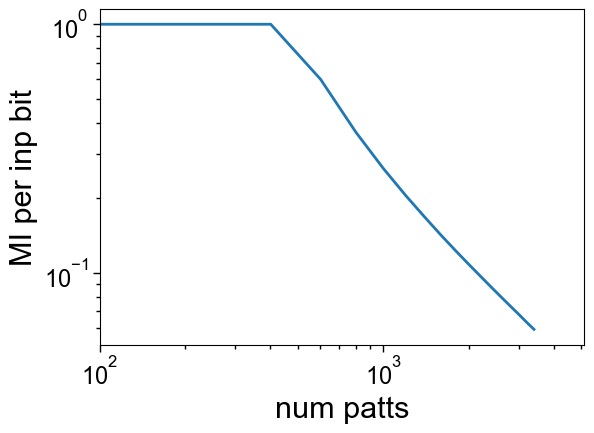

In [5]:
### FOR BINARY PATTS
normlizd_l1 = err_sensl1
Npatts = np.array(nruns*[Npatts_lst])   # Npatts_lst repeated nruns times
Npatts = Npatts.T
print(Npatts.shape)

m = 1 - (2*normlizd_l1) 
print(m.shape)

a = (1+m)/2
b = (1-m)/2

S = - a * np.log2(a) - b * np.log2(b)
S = np.where(m==1, np.zeros_like(S), S)

MI = 1 - S
plt.errorbar(Npatts_lst,MI[0].mean(axis=1),yerr=MI[0].std(axis=1),lw=2); plt.xscale('log'); plt.yscale('log');
plt.xlim(xmin=100)
plt.ylabel('MI per inp bit')
plt.xlabel('num patts')
plt.show()

### FOR CTS PATTS (miniimagenet_BW)
# m = err_sens
# plt.errorbar(Npatts_lst,m[0].mean(axis=1),yerr=m[0].std(axis=1)); #plt.xscale('log'); plt.yscale('log');
# plt.plot(np.linspace(Np_lst[0],max(Npatts_lst),10),np.sqrt(Np_lst[0]/np.linspace(Np_lst[0],max(Npatts_lst),10)),'k-')
# plt.ylabel('cosine sim')
# plt.xlabel('num patts')
# plt.show()


## 11. Basin of Attraction Experimental Implementation

### 11.1 Pattern Corruption and Recovery Testing

Implement comprehensive basin of attraction analysis using progressive noise levels:

#### 11.1.1 Experimental Setup
**Network Configuration:**
- **Pattern Generation**: `sbook = sign(randn(3600, 3600))` - Random binary patterns
- **Fixed Parameters**: `Npatts = 600` patterns for consistent analysis
- **Weight Training**: `Wsp` and `Wps` trained on uncorrupted patterns
- **Architecture**: Standard Vector-HaSH with learned place cell mappings

#### 11.1.2 Corruption Protocol
**Noise Level Testing:**
- **Range**: `noise_vals = arange(0, 0.55, 0.05)` - 0% to 50% corruption in 5% steps
- **Mechanism**: Random bit flips with probability `noise_val`
- **Implementation**: `sinit*sign(uniform(0,1) - noise_val)` corrupts patterns
- **Statistical Validation**: `basin_runs = 100` independent trials per noise level

#### 11.1.3 Recovery Assessment
**Vector-HaSH Processing Pipeline:**
1. **Sensory→Place**: `pin = nonlin(Wps@sinit, thresh=0)` 
2. **Place→Grid**: `gin = Wgp@pin`
3. **Grid Dynamics**: `g = gridCAN_2d(gin, lambdas)` - Attractor network
4. **Grid→Place**: `p = nonlin(Wpg@g, thresh)`
5. **Place→Sensory**: `sout = sign(Wsp@p)` - Final reconstruction

#### 11.1.4 Performance Metrics
**Error Quantification:**
- **Pattern Error**: `err = ||sout - sout_target||` - L2 reconstruction error
- **Success Criterion**: `correct = err < 1e-6` - Near-perfect recovery
- **Success Rate**: Proportion of patterns correctly recovered per noise level
- **Individual Tracking**: Performance for each of 600 test patterns

#### 11.1.5 Visualization and Analysis
**Basin Size Characterization:**
- **Individual Curves**: Performance for randomly selected patterns (gray lines)
- **Average Performance**: Mean success rate across all patterns (black line)
- **Noise Tolerance**: Identify maximum corruption level with reliable recovery
- **Basin Boundary**: Transition point where recovery degrades significantly

#### 11.1.6 Expected Results
**Robust Pattern Completion:**
- **Low Noise (0-20%)**: Near-perfect recovery (>95% success rate)
- **Moderate Noise (20-40%)**: Gradual degradation but substantial recovery
- **High Noise (>40%)**: Sharp drop in recovery capability
- **Individual Variation**: Some patterns more robust than others due to overlap structure

#### 11.1.7 Biological and Technical Significance
This basin analysis demonstrates:
- **Error Correction**: Vector-HaSH's ability to complete partial patterns
- **Noise Robustness**: Practical performance under realistic input corruption
- **Memory Stability**: Basin size indicating attractor strength
- **Hippocampal Modeling**: Pattern completion resembling biological memory systems

$\textcolor{red}{Note \ : \ the \ orginal \ code \ has \ forgotten \ definition\ of \ some\ parameters \  }$

$\textcolor{red}{What \ Ji \ lab\ newly \ added \ would \ be \ noted. }$

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


(0.0, 1.0)

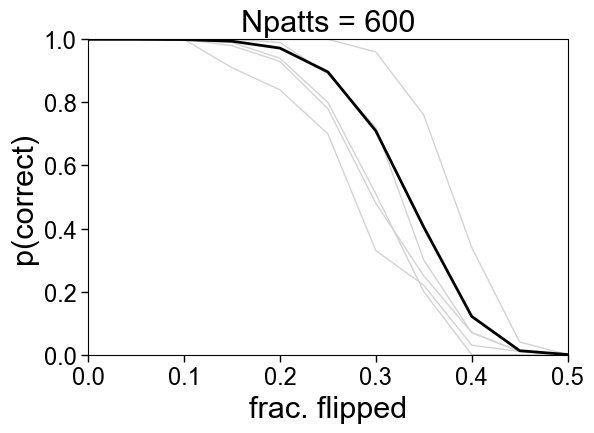

In [ ]:
###Code to examine basin sizes

#######Ji lab newly added
lambdas = [3,4,5]                   # module period
M = len(lambdas)                             # num modules
Ng = np.sum(np.square(lambdas))                             # num grid cells
Npos = np.prod(lambdas)   
Npos = Npos*Npos
gbook = gen_gbook([l**2 for l in lambdas],Ng,Npos)
Ns = Npos#84*84*3                           # num of sensory cells set at Npos, can be larger
Np_lst = [400] #np.arange(25, 425, 25)     # num place cells
pflip = 0.0                         #measure of noise injected in s (prob of flipping if binary, gaussian noise if cts)
Niter = 1                           # number of iterations for scaffold dynamics
nruns=1
sparsity=0        #Dummy param for older code, not used currently
Np=400                                  # number of place cells


Wpg = randn(nruns, Np, Ng)         # random grid→place weights
c = 0.60                           # connection probability (60% connectivity)
prune = int((1-c)*Np*Ng)          # number of connections to remove
mask = np.ones((Np, Ng))          # start with full connectivity
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)      # apply sparse connectivity mask


thresh=0.5                        # activation threshold for place cells
pbook = nonlin(np.einsum('ijk,kl->ijl', Wpg, gbook), thresh)  # place cell responses: (1, 400, 3600)
Wgp = train_gcpc(pbook, gbook, Npos)  # learn place→grid weights through associative training
#######


sbook = np.sign(np.random.normal(0,1,(np.prod(lambdas)**2,np.prod(lambdas)**2)))
nruns=1
Npatts=600
Wsp = pseudotrain_Wsp(sbook, pbook, Npatts)
Wps = pseudotrain_Wps(pbook, sbook, Npatts)

noise_vals = np.arange(0,0.55,0.05)
basin_runs = 100
correct = np.zeros((basin_runs,len(noise_vals),Npatts))
for bidx in tqdm(range(basin_runs)):
    # noise = np.random.normal(0,1,sinit.shape)
    for nidx,noise_val in enumerate((noise_vals)):
        sinit = sbook[:,:Npatts]
        sinit= sinit*np.sign(   np.random.uniform(0,1,size=sinit.shape) - noise_val  )
        pin = nonlin(Wps@sinit[:,:Npatts], thresh=0)

        #Project the hippocampal state onto the grid cell space to obtain the external input/initial drive for each grid cell.
        gin = Wgp@pin 

        #In a two-dimensional continuous attractor network ( CAN), 
        #based on gin as an external drive, the internal recursive dynamics of grid cells operate, causing activity in each module to converge into a stable 'activity bump'.
        g = gridCAN_2d(gin,lambdas)
        p = nonlin(Wpg@g, thresh)
        sprenonlin=Wsp@p
        sout = np.sign(sprenonlin)
        
        pin_t = nonlin(Wps@sbook[:,:Npatts], thresh=0)
        gin_t = Wgp@pin_t
        g_t = gridCAN_2d(gin_t,lambdas)
        p_t = nonlin(Wpg@g_t, thresh)
        sprenonlin_t=Wsp@p_t
        sout_t = np.sign(sprenonlin_t)
        
        err = np.linalg.norm(sout - sout_t,axis=1)
        correct[bidx,nidx] = err.squeeze()#<1e-6
     
correct_valid = correct<1e-6
correct_per_pat = correct_valid.mean(axis=0)

[plt.plot(noise_vals,correct_per_pat[:,i],color='lightgray') for i in np.random.randint(0,Npatts,5)];
plt.plot(noise_vals,correct_per_pat.mean(axis=1),'k',lw=2.);
plt.xlabel(r'frac. flipped');
plt.ylabel('p(correct)');
plt.title('Npatts = '+str(Npatts))
plt.xlim(0,0.5)
plt.ylim(0,1)

## 12. Novelty Detection Implementation Through Hippocampal States

### 12.1 Statistical Threshold-Based Pattern Classification

Implement novelty detection using place cell activation statistics:

#### 12.1.1 Experimental Design
**Pattern Sets:**
- **Stored Patterns**: `sbook[:,:Npatts]` - Training set patterns
- **Novel Patterns**: `snew = sign(randn(Ns, Npos))` - Completely new random patterns
- **Pattern Range**: `Npatts_lst = arange(1, 3601, 400)` - Test different memory loads
- **Classification Task**: Distinguish stored vs. novel based on place cell responses

#### 12.1.2 Statistical Baseline Establishment
**Place Cell Activation Analysis:**
- **Response Calculation**: `pin = nonlin(Wps@sbook, thresh=0)` for stored patterns
- **Statistical Parameters**: 
  - `mu = average(pin.mean(axis=0)) ≈ 0.341` - Mean place cell activation
  - `std = std(pin.mean(axis=0)) ≈ 0.035` - Standard deviation of activations
- **Threshold Factor**: `stdf = 2.` - Number of standard deviations for decision boundary

#### 12.1.3 Classification Protocol
**Decision Criterion:**
- **Normal Range**: `mu - stdf*std < activation < mu + stdf*std`
- **Stored Pattern Indicator**: Place activation within normal statistical range
- **Novel Pattern Indicator**: Place activation outside normal statistical range
- **Binary Classification**: Familiar vs. unfamiliar based on activation statistics

#### 12.1.4 Performance Metrics
**Classification Outcomes:**
- **True Positive (TP)**: Stored patterns correctly identified as familiar
- **True Negative (TN)**: Novel patterns correctly identified as unfamiliar  
- **False Positive (FP)**: Novel patterns incorrectly identified as familiar
- **False Negative (FN)**: Stored patterns incorrectly identified as unfamiliar

#### 12.1.5 Capacity-Dependent Analysis
**Memory Load Effects:**
- **Low Pattern Counts**: High classification accuracy for both stored and novel
- **Increasing Load**: Gradual degradation in discrimination ability
- **Capacity Approach**: Increased false classification rates
- **Performance Curves**: TP and TN rates vs. pattern count

#### 12.1.6 Visualization and Interpretation
**Classification Performance:**
- **TP Curve**: Shows recognition accuracy for stored patterns
- **TN Curve**: Shows novelty detection accuracy for new patterns
- **Capacity Scaling**: How discrimination degrades with memory load
- **Statistical Reliability**: Performance across different pattern counts


100%|██████████| 9/9 [00:17<00:00,  1.89s/it]


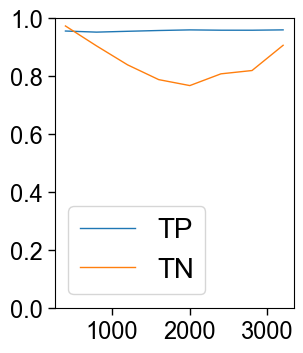

In [8]:
##Novelty detection through hippocampal states

import pickle
Npatts_lst=np.arange(1,Npos+1,400)
num_Npatts = len(Npatts_lst)

TP = np.zeros(num_Npatts)
TN = np.zeros(num_Npatts)
FP = np.zeros(num_Npatts)
FN = np.zeros(num_Npatts)

Npatts = Npos
snew = np.sign(randn(Ns, Npos))
Wps = pseudotrain_Wps(pbook, sbook, Npatts)
pin = nonlin(Wps@sbook[:,:Npatts], thresh=0)
mu = np.average(pin[0].mean(axis=0)) # approx 0.341
std = np.std(pin[0].mean(axis=0))    # approx 0.035
stdf=2.
for i in tqdm(range(num_Npatts)):
  Npatts = Npatts_lst[i]
  Wps = pseudotrain_Wps(pbook, sbook, Npatts)
  
  pin = nonlin(Wps@sbook[:,:Npatts], thresh=0)
  pnew = nonlin(Wps@snew[:,:Npatts], thresh=0)
  
  in_means = pin[0].mean(axis=0)
  new_means = pnew[0].mean(axis=0)
  
  TP[i] = sum((in_means>mu-stdf*std)*(in_means<mu+stdf*std))/Npatts
  TN[i] = sum((new_means<mu-stdf*std)+(new_means>mu+stdf*std))/Npatts
  FN[i] = sum((in_means<mu-stdf*std)+(in_means>mu+stdf*std))/Npatts
  FP[i] = sum((new_means>mu-stdf*std)*(new_means<mu+stdf*std))/Npatts

plt.figure(figsize=(3.5,4))
plt.plot(Npatts_lst[1:],TP[1:],label=('TP'));
# plt.plot(Npatts_lst[1:],FN[1:],label=('FN'));
# plt.plot(Npatts_lst[1:],FP[1:],label=('FP'));
plt.plot(Npatts_lst[1:],TN[1:],label=('TN'));
# plt.xlim(0,3600);
plt.ylim(0,1)
plt.legend()

## 13. Real-World Data Validation: Black-and-White Mini-ImageNet

### 13.1 Natural Image Pattern Testing

Validate Vector-HaSH performance on realistic visual patterns using grayscale Mini-ImageNet:

#### 13.1.1 Dataset Configuration
**Image Processing:**
- **Source**: `BW_miniimagenet_3600_60_60_full_rank.npy` - Preprocessed grayscale natural images
- **Resolution**: 60×60 pixels reshaped to 3600-dimensional vectors
- **Normalization**: `sbook - bw_mean` centering data around zero mean
- **Class Shuffling**: `indices = [arange(i, 3600, 600) for i in range(600)]` prevents class imbalance

#### 13.1.2 Architecture Configuration
**Network Parameters:**
- **Place Cells**: `Np = 400` optimized for natural image complexity
- **Connectivity**: `c = 0.60` (60% connection probability for grid→place weights)
- **Sparsity**: Pruned connections via random masking
- **Threshold**: `thresh = 0.5` for place cell activation

#### 13.1.3 Specialized Processing for Continuous Data
**Continuous Pattern Handling:**
- **Input Scaling**: `interp(sbook, (min, max), (-0.95, +0.95))` maps to activation range
- **Inverse Transform**: `arctanh(sbook_scaled)` linearizes for weight training
- **Weight Learning**: `Wsp` and `Wps` trained on linearized patterns
- **Output Recovery**: `tanh(sprenonlin)` followed by inverse scaling

#### 13.1.4 Vector-HaSH Processing Pipeline
**Complete Processing Cycle:**
1. **Sensory Input**: Natural image patterns (continuous values)
2. **Sensory→Place**: `pin = nonlin(Wps@sbook, thresh=0)`
3. **Place→Grid**: `gin = Wgp@pin` 
4. **Grid Dynamics**: `g = gridCAN_2d(gin, lambdas)` - Spatial attractor network
5. **Grid→Place**: `p = nonlin(Wpg@g, thresh)`
6. **Place→Sensory**: `sout = interp(tanh(Wsp@p), (-0.95,+0.95), (min,max))`


$\textcolor{red}{Note \ : \ Ji \ lab \ has \ changed \ the \ location \ of \ `.npy` \ file \ , \ please \ make \ sure \ change \ to \ your \ location }$

thresh=0.5


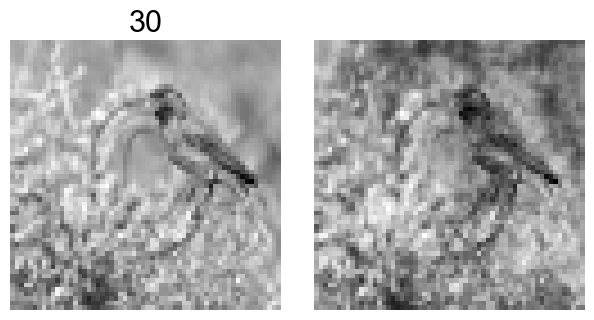

In [ ]:
#Barebones code to peek in and examine states etc. (BW miniimagenet)

Np = 400
Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh=0.5
#thresh=-5

print('thresh='+str(thresh))
pbook = nonlin(np.einsum('ijk,kl->ijl', Wpg, gbook), thresh)  # (nruns, Np, Npos)
Wgp = train_gcpc(pbook, gbook, Npos)

Npatts=500

##### please  make  sure  change  to  your  location 
sbook = np.load('BW_miniimagenet_3600_60_60_full_rank.npy').reshape((3600,3600)).T  
bw_mean = np.mean(sbook.flatten())
sbook = sbook - bw_mean
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[:,indices]

sbookmin = np.amin(sbook); sbookmax = np.amax(sbook);
sbook_scaled = np.interp(sbook, (sbookmin, sbookmax), (-0.95, +0.95))
sbookinv = np.arctanh(sbook_scaled)
Wsp = pseudotrain_Wsp(sbookinv, pbook, Npatts)
Wps = pseudotrain_Wps(pbook, sbook, Npatts)
pin = nonlin(Wps@sbook[:,:Npatts], thresh=0)
gin = Wgp@pin
g = gridCAN_2d(gin,lambdas)
p = nonlin(Wpg@g, thresh)
sprenonlin=Wsp@p
sout_prescale = np.tanh(sprenonlin)
sout = np.interp(sout_prescale,(-0.95,+0.95),(sbookmin,sbookmax))
imgno=30
fi,ax=plt.subplots(1,2)
ax[0].imshow(sbook[:,imgno].reshape((60,60)),cmap='gray');
ax[0].set_axis_off()
ax[0].set_title(str(imgno))
ax[1].imshow(sout[0,:,imgno].reshape((60,60)),cmap='gray');
ax[1].set_axis_off()


## 14. High-Dimensional Visual Data: Color Mini-ImageNet Testing

### 14.1 Full-Color Natural Image Processing

Test Vector-HaSH with high-dimensional color natural images from Mini-ImageNet dataset:

#### 14.1.1 Enhanced Dataset Configuration
**Color Image Processing:**
- **Source**: `miniimagenet_3600_84_84_3.npy` - Full-color natural images
- **Dimensions**: 84×84×3 (RGB) = 21,168-dimensional feature vectors
- **Complexity**: 6× higher dimensionality than grayscale version
- **Normalization**: `sbook - c_images_avg` centering RGB values
- **Class Organization**: Shuffled to prevent class imbalance effects

#### 14.1.2 Scaled Architecture Requirements
**High-Dimensional Processing:**
- **Sensory Dimension**: `Ns = 84×84×3 = 21,168` input features
- **Place Cells**: `Np = 400` managing increased input complexity  
- **Grid Representation**: Same 50-cell spatial compression (420× compression ratio)
- **Connectivity**: 60% sparse grid→place connections for computational efficiency

#### 14.1.3 Color-Specific Processing Pipeline
**RGB Pattern Handling:**
- **Input Range**: Full RGB color space with mean subtraction
- **Scaling Protocol**: `interp(sbook, (min, max), (-0.95, +0.95))` for activation compatibility
- **Weight Training**: Learned mappings for high-dimensional color patterns
- **Color Reconstruction**: Full RGB output with original color range restoration

#### 14.1.4 Vector-HaSH Color Processing Cycle
**Complete Multi-Channel Pipeline:**
1. **RGB Input**: 84×84×3 color natural images
2. **Sensory→Place**: `pin = nonlin(Wps@sbook, thresh=0)` - Color to spatial mapping
3. **Place→Grid**: `gin = Wgp@pin` - Spatial compression to grid representation
4. **Grid Dynamics**: `g = gridCAN_2d(gin, lambdas)` - Multi-scale spatial processing
5. **Grid→Place**: `p = nonlin(Wpg@g, thresh)` - Spatial to place cell mapping
6. **Place→Sensory**: `sout = interp(tanh(Wsp@p), (-0.95,+0.95), (min,max))` - RGB reconstruction



thresh=0.5


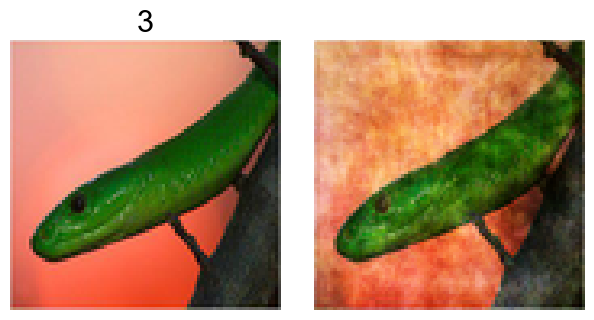

In [11]:
#Barebones code to peek in and examine states etc.  (miniimagenet)

Np = 400
Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh=0.5
#thresh=-5

print('thresh='+str(thresh))
pbook = nonlin(np.einsum('ijk,kl->ijl', Wpg, gbook), thresh)  # (nruns, Np, Npos)
Wgp = train_gcpc(pbook, gbook, Npos)

Npatts=500
c_miniimagenet = np.load("miniimagenet_3600_84_84_3.npy")
sbook =c_miniimagenet.reshape((3600,84*84*3)).T
c_images_avg = np.mean(sbook.flatten())
sbook = sbook - c_images_avg
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[:,indices]


sbookmin = np.amin(sbook); sbookmax = np.amax(sbook);
sbook_scaled = np.interp(sbook, (sbookmin, sbookmax), (-0.95, +0.95))
sbookinv = np.arctanh(sbook_scaled)
Wsp = pseudotrain_Wsp(sbookinv, pbook, Npatts)
Wps = pseudotrain_Wps(pbook, sbook, Npatts)
pin = nonlin(Wps@sbook[:,:Npatts], thresh=0)
gin = Wgp@pin
g = gridCAN_2d(gin,lambdas)
p = nonlin(Wpg@g, thresh)
sprenonlin=Wsp@p
sout_prescale = np.tanh(sprenonlin)
sout = np.interp(sout_prescale,(-0.95,+0.95),(sbookmin,sbookmax))
imgno=3
fi,ax=plt.subplots(1,2)
ax[0].imshow(sbook[:,imgno].reshape((84,84,3))+c_images_avg);
ax[0].set_axis_off()
ax[0].set_title(str(imgno))
ax[1].imshow(sout[0,:,imgno].reshape((84,84,3))+c_images_avg);
ax[1].set_axis_off()


## 15. Baseline Method Implementation: Hopfield Network Utilities

### 15.1 Classical Associative Memory Baseline Functions

Implement comprehensive utility functions for Hopfield network baselines and comparative analysis:

#### 15.1.1 Weight Constraint Functions
**Bounded Learning (`cap` function):**
- **Purpose**: Implement bounded Hopfield networks with weight limits
- **Mechanism**: `W = clip(W, -bound, +bound)` prevents weight explosion
- **Application**: Bounded Hebbian learning for stable associative memory
- **Parameter**: `bound` controls maximum synaptic strength

#### 15.1.2 Pattern Corruption Utilities
**Noise Injection (`corrupt_p` function):**
- **Binary Patterns (-1,+1)**: Random bit flips with probability `p`
- **Binary Patterns (0,1)**: Complementary bit flips for 0/1 encoding
- **Continuous Patterns**: Gaussian noise addition with standard deviation `p`
- **Flexibility**: Handles different pattern encodings for baseline comparisons

#### 15.1.3 Weight Matrix Generation
**Learning Rule Implementation (`get_weights` function):**

**Hebbian Learning:** 
- **Formula**: `W = patterns @ patterns.T` - Classical outer product rule
- **Properties**: Symmetric weights, unlimited growth
- **Application**: Standard Hopfield network implementation

**Sparse Hebbian Learning:**
- **Formula**: `W = (patterns - prob) @ (patterns - prob).T / N`
- **Modification**: Bias correction for sparse binary patterns
- **Application**: Optimized for sparse activity patterns

**Pseudoinverse Learning:**
- **Formula**: `W = patterns @ pinv(patterns)` - Optimal linear reconstruction
- **Properties**: Exact storage for linearly independent patterns
- **Application**: Maximum capacity Hopfield variant

**Bounded Hebbian Learning:**
- **Formula**: Iterative `W = clip(W + outer(pattern_i, pattern_i)/√N, -bound, +bound)`
- **Properties**: Prevents weight saturation while maintaining plasticity
- **Application**: Stable learning with capacity control

#### 15.1.4 Sparse Connectivity Support
**Connectivity Matrices:**
- **Standard**: Full connectivity `connectivity='standard'`
- **Sparse**: Custom sparse matrices with defined connection patterns
- **Implementation**: Sparse matrix operations for computational efficiency
- **Flexibility**: Variable connectivity patterns for network topology studies

#### 15.1.5 Information-Theoretic Analysis
**Entropy Calculation:**
- **Binary Entropy**: `H(p) = -p*log₂(p) - (1-p)*log₂(1-p)`
- **Edge Cases**: Handle p=0 and p=1 with zero entropy
- **Application**: Mutual information calculation for baseline methods
- **Performance**: Quantify information storage capacity


In [12]:
###Baselines
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from src.data_utils import read_pkl, write_pkl
from tqdm import tqdm as tqdm


def cap(W,bound):
    W1=np.where(W>bound,bound*np.ones(W.shape),W)
    W2=np.where(W1<-bound,-bound*np.ones(W.shape),W1)
    return W2

def corrupt_p(codebook,p=0.1,booktype='-11'):
    rand_indices = np.sign(np.random.uniform(size=codebook.shape)- p )
    if booktype=='-11':
        return np.multiply(codebook,rand_indices)
    elif booktype=='01':
        return abs(codebook - 0.5*(-rand_indices+1))
    elif booktype=='cts':
        return codebook + np.random.normal(0,1,size=codebook.shape)*p
    else:
        print("codebook should be -11; 01; or cts")
        return 0


def get_weights(patterns,connectivity):
    if connectivity is 'standard':
        if learning == 'hebbian':
            W = patts @ patts.T
        elif learning == 'sparsehebbian':
            prob = sparsity #np.sum(patts)/patts.shape[0]/patts.shape[1]
            W =(1/patts.shape[0])* (patts - prob) @ (patts.T - prob)
        elif learning == 'pinv':
            W= patts @ np.linalg.pinv(patts)
        elif learning == 'bounded_hebbian':
            num_patts = patts.shape[1]
            num_nodes = patts.shape[0]
            W = np.zeros((num_nodes,num_nodes))
            for i in range(num_patts):
                Wtmp = np.outer(patts[:,i] , patts[:,i])/np.sqrt(num_nodes)
                # ~ print(np.amax(Wtmp))
                W = cap(Wtmp + W,bound)
        W = W - np.diag(np.diag(W))
    else:
        N = connectivity.shape[0]
        W = sparse.lil_matrix(connectivity.shape)
        for i in range(N):
            for j in connectivity.rows[i]:
                W[i,j] = np.dot(patterns[i],patterns[j])
        W.setdiag(0)
    return W


def entropy(inlist):
    ent = np.zeros(len(inlist))
    for idx,x in enumerate(inlist):
        if x == 0 or x == 1:
            ent[idx] = 0
        else:
            ent[idx] = -1 * ( x*np.log2(x) + (1-x)*np.log2(1-x) )
    return ent

<>:28: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:28: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\DELL\AppData\Local\Temp\ipykernel_22852\3564347232.py:28: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if connectivity is 'standard':


## 16. Baseline Experimental Configuration

### 16.1 Hopfield Network Testing Parameters

Configure experimental parameters for comprehensive baseline method evaluation:

#### 16.1.1 Statistical Validation Parameters
**Experimental Reliability:**
- **`nruns = 10`**: Multiple independent trials for statistical significance
- **`iterations = 100`**: Maximum convergence iterations for Hopfield dynamics
- **Purpose**: Ensure robust statistical comparison with Vector-HaSH results
- **Analysis**: Mean and standard deviation across experimental runs

#### 16.1.2 Convergence and Dynamics
**Hopfield Network Dynamics:**
- **Iteration Limit**: 100 time steps for pattern convergence
- **Convergence Detection**: Early stopping when dynamics reach fixed point
- **Update Rule**: Synchronous or asynchronous state updates
- **Stability Analysis**: Identification of fixed points and limit cycles

#### 16.1.3 Comparative Framework
**Experimental Consistency:**
- **Pattern Generation**: Identical random patterns as Vector-HaSH experiments
- **Noise Protocols**: Same corruption levels for basin of attraction analysis
- **Performance Metrics**: Consistent overlap and mutual information measures
- **Statistical Testing**: Comparable experimental runs and data analysis

This configuration ensures fair and rigorous comparison between Vector-HaSH and classical associative memory approaches.

In [28]:
nruns=10
iterations=100

## 17. Standard Hopfield Network Baseline Implementation

### 17.1 Classical Associative Memory Evaluation

Implement comprehensive testing of standard Hopfield networks for direct comparison with Vector-HaSH:

#### 17.1.1 Network Configuration
**Hopfield Architecture:**
- **Size**: `N = 708` neurons (comparable to Vector-HaSH representational capacity)
- **Connectivity**: `'standard'` - fully connected symmetric network
- **Learning Rule**: `'hebbian'` - classical outer product learning
- **Pattern Range**: 1 to 800 patterns in steps of 10 for detailed capacity curve

#### 17.1.2 Pattern and Corruption Setup
**Input Configuration:**
- **Pattern Type**: Binary patterns `sign(randn(N, max_patterns))`
- **Corruption Level**: `corrupt_fraction = 0.0` for clean capacity analysis
- **Pattern Generation**: Random bipolar patterns (-1, +1) matching Vector-HaSH experiments
- **Consistency**: Identical pattern statistics for fair comparison

#### 17.1.3 Learning and Weight Formation
**Hebbian Weight Matrix:**
- **Formula**: `W = patterns @ patterns.T` - Classical associative learning
- **Normalization**: No diagonal terms (`W[i,i] = 0`)
- **Symmetry**: Symmetric weight matrix ensuring energy function
- **Capacity**: Theoretical limit ~0.14N for random patterns

#### 17.1.4 Dynamics and Convergence
**Hopfield Dynamics:**
- **Update Rule**: `sign(W @ current_state)` - Synchronous updates
- **Initialization**: Corrupted patterns as starting states
- **Convergence**: Fixed point detection or maximum iterations (100)
- **Energy Minimization**: Convergence to local energy minima

#### 17.1.5 Performance Metrics
**Comprehensive Evaluation:**
- **Initial Overlap**: `einsum('ij,ij->j', initial_state, targets)/N`
- **Final Overlap**: `einsum('ij,ij->j', final_state, targets)/N`
- **Mutual Information**: `MI = 1 - S` where `S = -a*log₂(a) - b*log₂(b)`
- **Statistical Analysis**: Mean and standard deviation across runs

#### 17.1.6 Information-Theoretic Analysis
**Capacity Quantification:**
- **Overlap to Probability**: `a = (1+overlap)/2`, `b = (1-overlap)/2`
- **Binary Entropy**: `S = -a*log₂(a) - b*log₂(b)`
- **Information Preservation**: `MI = 1 - S` measuring storage efficiency
- **Capacity Curves**: MI vs. pattern count showing storage limits



runidx = 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:07<00:00,  1.60s/it]


runidx = 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:12<00:00,  1.65s/it]


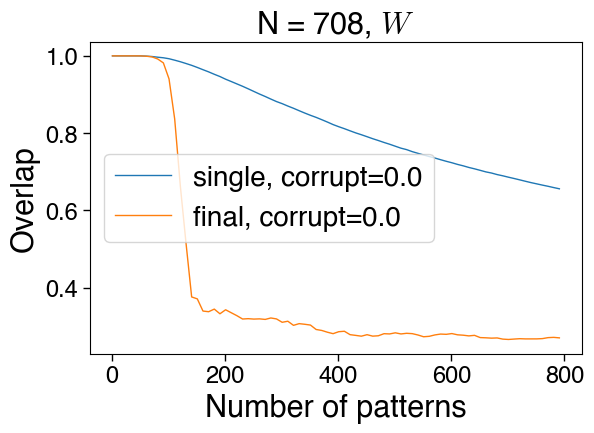

C:\Users\chand\AppData\Local\Temp\ipykernel_28496\3367553331.py:97: RuntimeWarning: divide by zero encountered in log2
  S = - a * np.log2(a) - b * np.log2(b)
C:\Users\chand\AppData\Local\Temp\ipykernel_28496\3367553331.py:97: RuntimeWarning: invalid value encountered in multiply
  S = - a * np.log2(a) - b * np.log2(b)


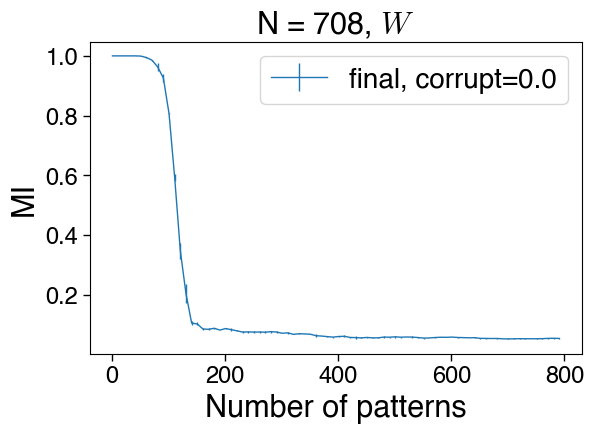

In [31]:
N = 708
corrupt_fraction = 0.0
Npatts_list = np.arange(1,800,10)
connectivity='standard' # Standard fully connected Hopfield network. For sparse connectivity use the next cell
# learning can be 'hebbian', 'bounded_hebbian', 'pinv', or 'sparsehebbian' for sparse hopfield network
learning='hebbian'
# bound=0.3  #Use bound param if learning='bounded_hebbian'

init_overlap = np.zeros((nruns,*Npatts_list.shape))
final_overlap = np.zeros((nruns,*Npatts_list.shape))
MI_hc = np.zeros((nruns,*Npatts_list.shape))


for runidx in range(nruns):
    print("runidx = "+str(runidx))
    
    if learning == 'sparsehebbian':
        # sparse hopfiled 0/1 code
        sparsity = 0.2
        patterns = 1*(np.random.rand(N,Npatts_list.max()) > (1-sparsity))
        corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='01')
    else:
        patterns = np.sign(np.random.normal(0,1,(N,Npatts_list.max())))
        corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='-11')


    for idx,Npatts in enumerate(tqdm(Npatts_list)):
        #print(Npatts)
        patts = patterns[:,:Npatts]
        cor_patts = corrupt_patts[:,:Npatts]
        W = get_weights(patts,connectivity)
        
        if learning == 'sparsehebbian':
            # sparse hopfield
            theta = np.sum(W-np.diag(W), axis=1)
            theta=0.05 #0.04 #0
            rep = (np.sign(W@cor_patts - theta)+1)/2            
        else:
            rep = np.sign(W@cor_patts)

        init_overlap[runidx,idx] = np.average(np.einsum('ij,ij->j',rep,patts)/N) 

        rep1 = np.copy(rep)
        for ite in range(iterations-1):
            if learning == 'sparsehebbian':
                rep = (np.sign(W@rep - theta)+1)/2
            else:
                rep = np.sign(W@rep)
            
            if np.sum(abs(rep - rep1))>0:
                rep1 = np.copy(rep)
            else:
                # print("converged at "+str(ite))
                break
        err = np.einsum('ij,ij->j',rep,patts)/N
        overlap = np.average(err) 
        final_overlap[runidx,idx] = overlap #err
        
        if learning=='sparsehebbian':
            q = np.sum(np.abs(rep), axis=0) / N  # sparse hopfield
            m = err
            p = np.sum(patts, axis=0)/patts.shape[0]
            P1e = 1 - (m/p)
            P0e = (q-m)/(1-p)
            MI_hc[runidx,idx] =  np.average( entropy(q) - ( p*entropy(P1e) + (1-p)*entropy(P0e) ) )


# print(init_overlap)
# print(final_overlap)

results_dir = "continuum_results"
# filename = f"sparseconnhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_gamma={gamma}_iter={iterations}_nruns={nruns}"
filename = f"stdhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_iter={iterations}_nruns={nruns}"
# filename = f"pinvhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_iter={iterations}_nruns={nruns}"
# filename = f"sparsehopfield__mutualinfo_N={N}_noise={corrupt_fraction}_p={sparsity}_iter={iterations}_nruns={nruns}"
# filename = f"boundedhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_bound={bound}_iter={iterations}_nruns={nruns}"


fig1 = plt.figure(1)
plt.plot(Npatts_list,init_overlap.mean(axis=0), label='single, corrupt='+str(corrupt_fraction));
plt.plot(Npatts_list,final_overlap.mean(axis=0), label='final, corrupt='+str(corrupt_fraction));
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("Overlap");
plt.title(r"N = "+str(N)+", $W$");
plt.show()
# exit()
# fig1.savefig(f"{results_dir}/Overlap_{filename}.png")

if learning=='sparsehebbian':
    print("MI already calculated in loop")
else:
    m = final_overlap
    a = (1+m)/2
    b = (1-m)/2

    S = - a * np.log2(a) - b * np.log2(b)
    S = np.where(m==1, np.zeros_like(S), S)

    MI_hc = 1 - S


fig2 = plt.figure(1)
plt.errorbar(Npatts_list,MI_hc.mean(axis=0),yerr=MI_hc.std(axis=0), label='final, corrupt='+str(corrupt_fraction)); #plt.xscale('log'); plt.yscale('log');
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("MI");
plt.title(r"N = "+str(N)+", $W$");
plt.show()
# fig2.savefig(f"{results_dir}/MI_{filename}.png")

data = {
    "N": N,
    "init_overlap": init_overlap,
    "m": final_overlap,
    "MI": MI_hc,
    "Npatts_list": Npatts_list,
    "noise": corrupt_fraction,
    # "q": q  #needed for sparse hebbian
    # "bound": bound #needed for bounded hopfield
}
# write_pkl(f"{results_dir}/{filename}", data)

## 18. Sparse Connectivity Hopfield Network Implementation

### 18.1 Ultra-Sparse Associative Memory Baseline

Implement Hopfield networks with severely limited connectivity to test Vector-HaSH advantages:

#### 18.1.1 Sparse Network Architecture
**Extreme Sparsity Configuration:**
- **Network Size**: `N = 7071` neurons (10× larger for statistical power)
- **Connectivity**: `gamma = 1e-2` (1% connection probability)
- **Sparsity**: Only ~71 connections per neuron vs. 7071 in full network
- **Pattern Range**: Reduced to `arange(1, 100, 20)` due to capacity limitations

#### 18.1.2 Sparse Connectivity Matrix Generation
**Random Sparse Topology:**
- **Structure**: `sparse.lil_matrix((N,N))` for efficient sparse operations
- **Connection Pattern**: Each neuron randomly connected to `int(gamma*N)` others
- **Symmetry**: May be asymmetric unlike standard Hopfield networks
- **Memory Efficiency**: Sparse matrix storage for large-scale networks

#### 18.1.3 Sparse Weight Learning
**Modified Hebbian Learning:**
- **Weight Calculation**: `W[i,j] = dot(patterns[i], patterns[j])` only for existing connections
- **Sparse Operations**: Efficient computation using sparse matrix routines
- **Zero Diagonal**: `W.setdiag(0)` removes self-connections
- **Selective Learning**: Weights learned only where connections exist

#### 18.1.4 Sparse Network Dynamics
**Constrained Hopfield Dynamics:**
- **Update Rule**: `sign(W @ current_state)` with sparse matrix multiplication
- **Propagation**: Information flows only through existing connections
- **Convergence**: May be impaired due to limited connectivity
- **Stability**: Reduced basin sizes due to connection constraints



runidx = 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


runidx = 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.18s/it]


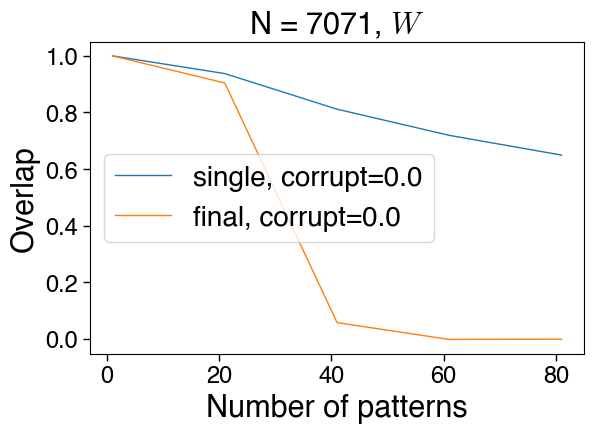

C:\Users\chand\AppData\Local\Temp\ipykernel_28496\1875080652.py:58: RuntimeWarning: divide by zero encountered in log2
  S = - a * np.log2(a) - b * np.log2(b)
C:\Users\chand\AppData\Local\Temp\ipykernel_28496\1875080652.py:58: RuntimeWarning: invalid value encountered in multiply
  S = - a * np.log2(a) - b * np.log2(b)


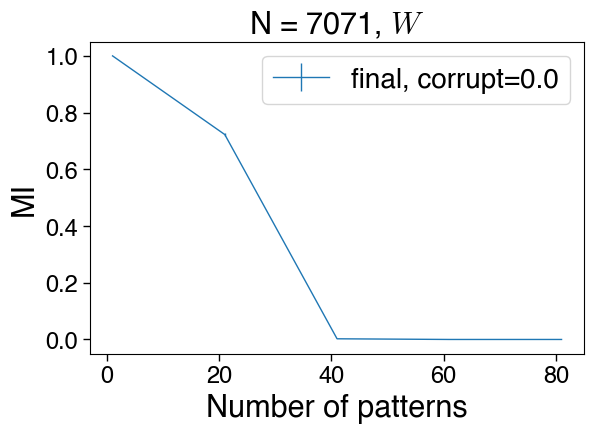

In [29]:
#Hopfield with sparse connectivity (For other variants of Hopfield model use above cell)
N = 7071
gamma = 1e-2
corrupt_fraction = 0.0
Npatts_list = np.arange(1,100,20)
connectivity = sparse.lil_matrix((N,N))
for i in range(N):
    connectivity[i,np.random.randint(0,N,int(gamma*N))] = 1

init_overlap = np.zeros((nruns,*Npatts_list.shape))
final_overlap = np.zeros((nruns,*Npatts_list.shape))
MI_hc = np.zeros((nruns,*Npatts_list.shape))

for runidx in range(nruns):
    print("runidx = "+str(runidx))
    patterns = np.sign(np.random.normal(0,1,(N,Npatts_list.max())))
    corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='-11')
    for idx,Npatts in enumerate(tqdm(Npatts_list)):
        patts = patterns[:,:Npatts]
        cor_patts = corrupt_patts[:,:Npatts]
        W = get_weights(patts,connectivity)
        rep = np.sign(W@cor_patts)

        init_overlap[runidx,idx] = np.average(np.einsum('ij,ij->j',rep,patts)/N) 

        rep1 = np.copy(rep)
        for ite in range(iterations-1):
            rep = np.sign(W@rep)
            if np.sum(abs(rep - rep1))>0:
                rep1 = np.copy(rep)
            else:
                break
        err = np.einsum('ij,ij->j',rep,patts)/N
        overlap = np.average(err) 
        final_overlap[runidx,idx] = overlap #err
        
    


results_dir = "continuum_results"
filename = f"sparseconnhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_gamma={gamma}_iter={iterations}_nruns={nruns}"

fig1 = plt.figure(1)
plt.plot(Npatts_list,init_overlap.mean(axis=0), label='single, corrupt='+str(corrupt_fraction));
plt.plot(Npatts_list,final_overlap.mean(axis=0), label='final, corrupt='+str(corrupt_fraction));
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("Overlap");
plt.title(r"N = "+str(N)+", $W$");
plt.show()
#fig1.savefig(f"{results_dir}/Overlap_{filename}.png")

m = final_overlap
a = (1+m)/2
b = (1-m)/2

S = - a * np.log2(a) - b * np.log2(b)
S = np.where(m==1, np.zeros_like(S), S)

MI_hc = 1 - S


fig2 = plt.figure(1)
plt.errorbar(Npatts_list,MI_hc.mean(axis=0),yerr=MI_hc.std(axis=0), label='final, corrupt='+str(corrupt_fraction)); #plt.xscale('log'); plt.yscale('log');
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("MI");
plt.title(r"N = "+str(N)+", $W$");
plt.show()
# fig2.savefig(f"{results_dir}/MI_{filename}.png")

data = {
    "N": N,
    "init_overlap": init_overlap,
    "m": final_overlap,
    "MI": MI_hc,
    "Npatts_list": Npatts_list,
    "noise": corrupt_fraction,
    # "q": q
    "gamma": gamma
    # "bound": bound
}
# write_pkl(f"{results_dir}/{filename}", data)